Columns in dataframe: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
Is 'Fjob' in columns? True


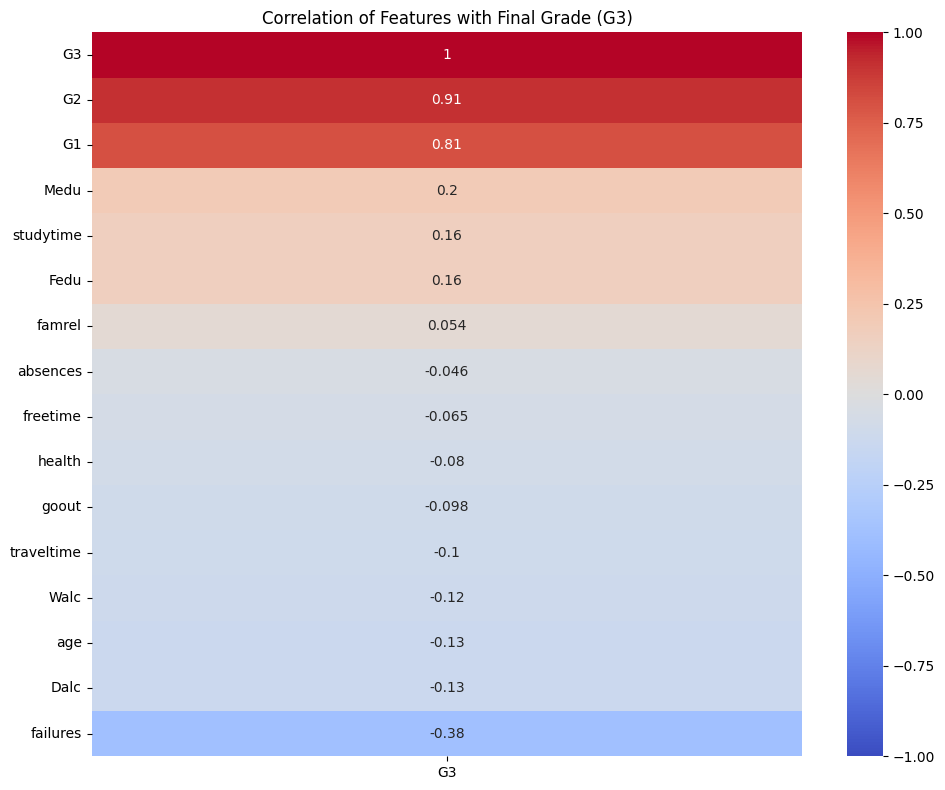

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     22.89
Date:                Wed, 07 May 2025   Prob (F-statistic):           4.24e-39
Time:                        22:30:35   Log-Likelihood:                -2787.8
No. Observations:                1044   AIC:                             5598.
Df Residuals:                    1033   BIC:                             5652.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              10.4248    

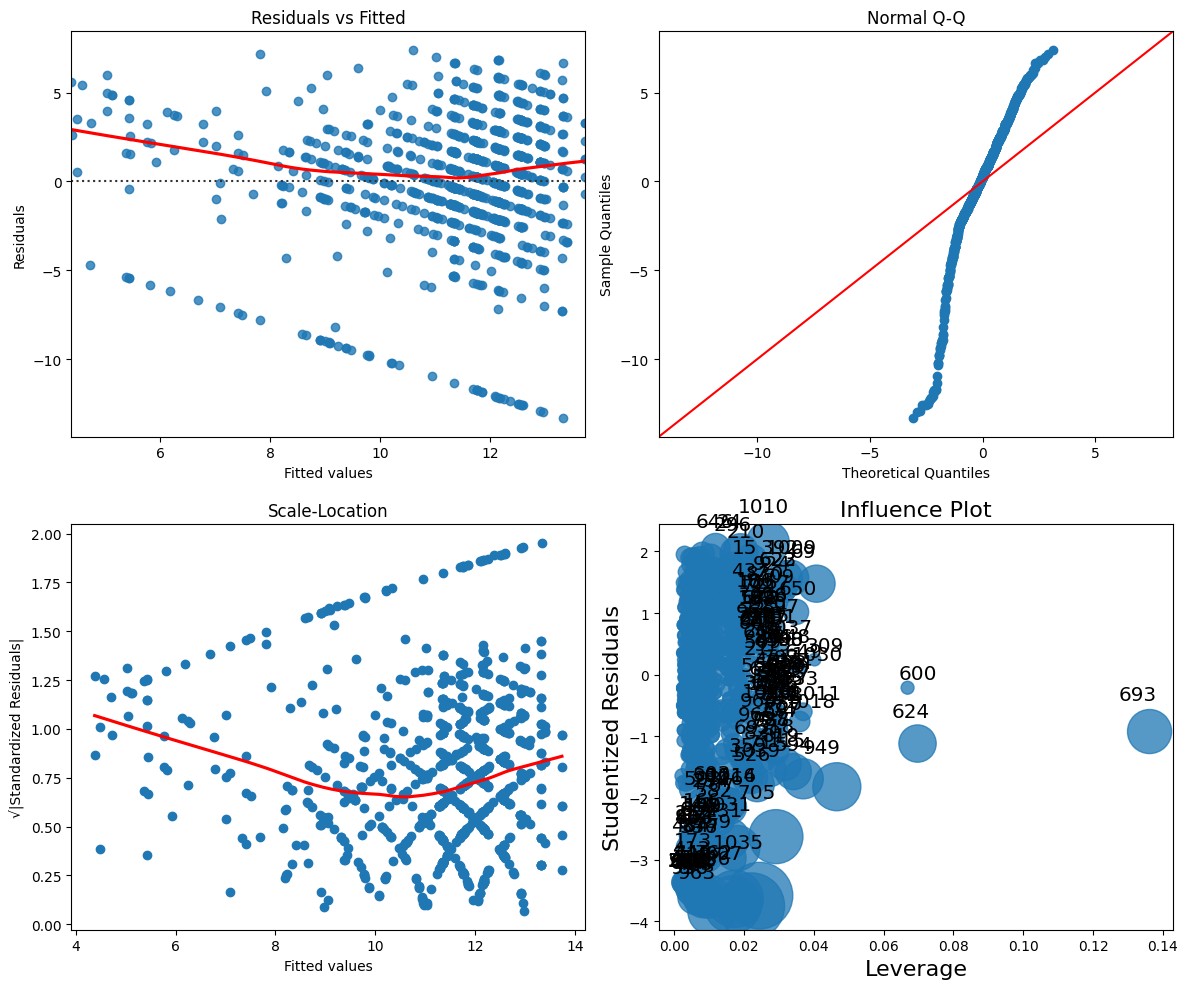

In [7]:
# === Import Required Libraries ===
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

# === Load and Merge Data ===
student_mat = pd.read_csv("student-mat.csv", sep=";")
student_por = pd.read_csv("student-por.csv", sep=";")

# Merge datasets on common columns
common_cols = list(set(student_mat.columns).intersection(set(student_por.columns)))
student_data = pd.merge(student_mat, student_por, on=common_cols, how='outer')

# Print columns to verify Fjob exists
print("Columns in dataframe:", student_data.columns.tolist())
print("Is 'Fjob' in columns?", 'Fjob' in student_data.columns)

# Convert relevant columns to numeric if not already
numeric_cols = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
                'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
                'absences', 'G1', 'G2', 'G3']
student_data[numeric_cols] = student_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Convert categorical columns
categorical_cols = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'guardian',
                   'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
                   'internet', 'romantic', 'Mjob', 'Fjob']
for col in categorical_cols:
    if col in student_data.columns:
        student_data[col] = student_data[col].astype('category')

# Drop rows with missing values
student_data.dropna(inplace=True)

# Compute and show correlation heatmap
correlation_matrix = student_data[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['G3']].sort_values('G3', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of Features with Final Grade (G3)')
plt.tight_layout()
plt.show()

# === Fit Linear Regression Model ===
# Use string for the formula to avoid variable name issues
formula = "G3 ~ Medu + Fedu + Dalc + studytime + failures + absences + C(Fjob)"
model = ols(formula, data=student_data).fit()
print(model.summary())

# === Residual Diagnostics ===
# Set up 2x2 plot layout
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# 1. Residuals vs Fitted
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, ax=axs[0, 0], line_kws={'color': 'red'})
axs[0, 0].set_title("Residuals vs Fitted")
axs[0, 0].set_xlabel("Fitted values")
axs[0, 0].set_ylabel("Residuals")

# 2. Q-Q Plot
sm.qqplot(model.resid, line='45', ax=axs[0, 1])
axs[0, 1].set_title("Normal Q-Q")

# 3. Scale-Location Plot
sqrt_std_resid = np.sqrt(np.abs(model.get_influence().resid_studentized_internal))
axs[1, 0].scatter(model.fittedvalues, sqrt_std_resid)
sns.regplot(x=model.fittedvalues, y=sqrt_std_resid, scatter=False, lowess=True, ax=axs[1, 0], line_kws={'color': 'red'})
axs[1, 0].set_title("Scale-Location")
axs[1, 0].set_xlabel("Fitted values")
axs[1, 0].set_ylabel("√|Standardized Residuals|")

# 4. Residuals vs Leverage
sm.graphics.influence_plot(model, ax=axs[1, 1], criterion="cooks")
plt.tight_layout()
plt.show()
